# Problem Statement 2

Problem Statement 2:
Sumanth wants to build an flowers image classification CNN model which can take a flower
image as input and prints the name of flower.

Dataset Description: The dataset consist of 3,700 photos of flowers. The dataset contains five
sub-directories, one per class:

• daisy

• dandelion

• roses

• sunflowers

• tulips

Tasks to be performed:

• Import all the required libraries

• Download the flowers data from URL:
'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_phot
os.tgz' using the Keras; and analyzing the images present in the dataset visualization

• Prepare the data by specifying the image resolution and batch size. Also, Splitting the
dataset into training and validation datasets in 80:20 ratio

• Plot a sample image attributed to each class name present in the original dataset.

• Autotune the data using cache().shuffle().prefetch() function; Also, normalize the data by
dividing it with a number

• Build a sequential CNN model

• Compile the model and print model summary

• Train and validate the model and plot the validation results using a line plot

• Feed the system with an image of a flower and print the prediction along with the
accuracy


In [1]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin = url, untar=True)


228827136/228813984 [==============================] - 11s 0us/step


In [3]:
data_dir

'/root/.keras/datasets/flower_photos'

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


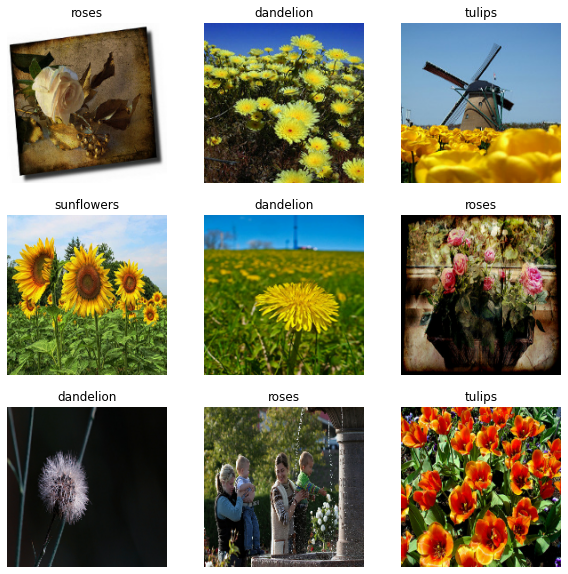

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.038006518 0.99523425


In [13]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

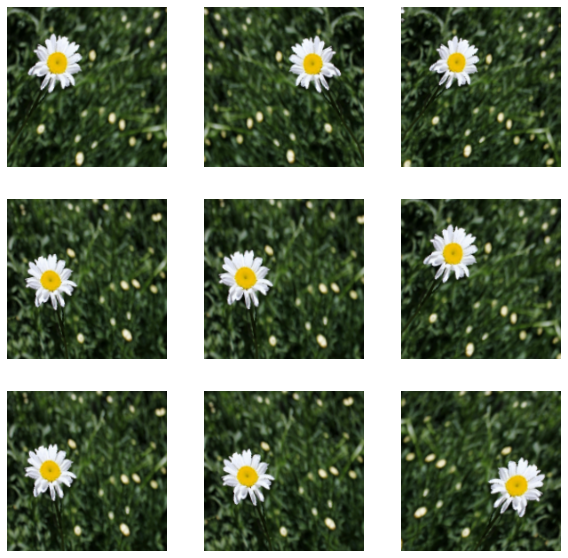

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
num_classes=5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 16s 42ms/step - loss: 1.4032 - accuracy: 0.4029 - val_loss: 1.1890 - val_accuracy: 0.5054
Epoch 2/20
92/92 [==============================] - 3s 28ms/step - loss: 1.1225 - accuracy: 0.5293 - val_loss: 1.1167 - val_accuracy: 0.5722
Epoch 3/20
92/92 [==============================] - 2s 26ms/step - loss: 1.0355 - accuracy: 0.5916 - val_loss: 0.9901 - val_accuracy: 0.5995
Epoch 4/20
92/92 [==============================] - 2s 26ms/step - loss: 0.9651 - accuracy: 0.6298 - val_loss: 0.9383 - val_accuracy: 0.6172
Epoch 5/20
92/92 [==============================] - 2s 26ms/step - loss: 0.8958 - accuracy: 0.6577 - val_loss: 0.9490 - val_accuracy: 0.6117
Epoch 6/20
92/92 [==============================] - 2s 26ms/step - loss: 0.8604 - accuracy: 0.6734 - val_loss: 0.9315 - val_accuracy: 0.6390
Epoch 7/20
92/92 [==============================] - 2s 26ms/step - loss: 0.8147 - accuracy: 0.6945 - val_loss: 0.8025 - val_accuracy: 0.6975
Epoch 8/20
9

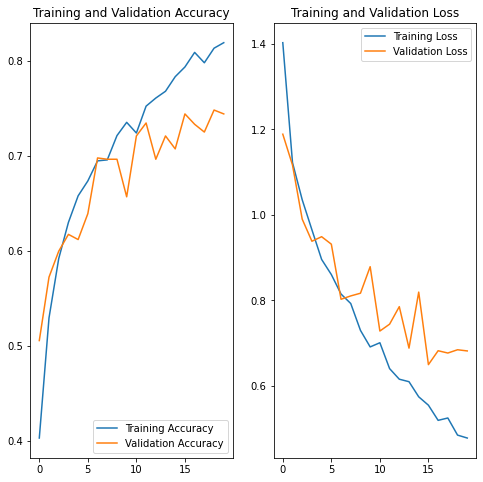

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4

In [20]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

Saving sunflower-1627193__340.webp to sunflower-1627193__340.webp


In [21]:
for fn in uploaded.keys():
  path='/content/' + fn
  print(path)
  img=image.load_img(path, target_size=(180, 180))
  
  x=image.img_to_array(img)
  test_img=np.expand_dims(x, axis=0)
  
  
  result = model.predict(test_img)
  pred = np.argmax(result) # get the index of max value

  print(pred)

/content/sunflower-1627193__340.webp
3


In [22]:
uploaded=files.upload()

Saving 6ir5azA5T.jpg to 6ir5azA5T.jpg


In [23]:
for fn in uploaded.keys():
  path='/content/' + fn
  print(path)
  img=image.load_img(path, target_size=(180, 180))
  
  x=image.img_to_array(img)
  test_img=np.expand_dims(x, axis=0)
  
  
  result = model.predict(test_img)
  pred = np.argmax(result) # get the index of max value

  print(pred)

/content/6ir5azA5T.jpg
2
